In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
def plot_learning_curve(sizes,train,val):
    train_scores_mean = np.mean(train, axis=1)
    train_scores_std = np.std(train, axis=1)
    val_scores_mean = np.mean(val, axis=1)
    val_scores_std = np.std(val, axis=1)

    _, axes = plt.subplots(1,)
    axes.grid()
    axes.fill_between(
        sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.fill_between(
        sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.plot(
        sizes, train_scores_mean, "o-", color="g", label="Training score"
    )
    axes.plot(
        sizes, val_scores_mean, "o-", color="r", label="Cross-validation score"
    )
    axes.legend(loc="best")
    
    plt.xlabel("Training Sizes")
    
    plt.show()
    return 

## Developing a Classifier in Complete Dataset

In [4]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")
DB2 = DB2P8[DB5.columns] # Because DB2P8 has more columns than DB5

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered almost severly skewed.

In [5]:
DB5.columns

Index(['ind', 'id', 'label', 'PHASE', 'TOK', 'IP', 'BT', 'NEL', 'PLTH', 'RGEO',
       'KAREA', 'EPS', 'MEFF', 'TAUTH', 'DATE', 'SHOT', 'TIME', 'Q95', 'ZEFF',
       'AMIN', 'VOL', 'POHM', 'PNBI', 'DWDIA', 'DWMHD', 'PICRH', 'PECRH', 'PL',
       'PFLOSS', 'TAV', 'LCOULOMB', 'QCYL5', 'TAUBOHM', 'RHOSTAR', 'BETASTAR',
       'NUSTAR', 'OMEGACYCL'],
      dtype='object')

### On the Metrics: What do you want to predict? 

Notes on [[Jason Browniee, 2020]](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)

* **PROBABILITIES**
    * If only probabilities needed: Brier Score
    * **With class label, if minority class is more important: PR AUC**
    * With class label, if both classes are equally important: ROC AUC
* **CLASS LABELS**
    * Both classes are euqally important: G-Mean
        * Not so severely skewed data: Accuracy
    * If minority class is more important: 
        * Both false positive and false negative are equally costly: F1 Score
        * False positives (minority) are more costly: F0.5 Score
        * False negatives (majority) are more costly: F2 Score
        
### Spot-Check on ML Algorithms


1. Linear Algorithms
2. Nonlinear Algorithms
3. Ensemble Algorthms
4. **Data Sampling Algorithms**
5. **One-Class Algorithms** (specialized on severely imbalanced datasets)

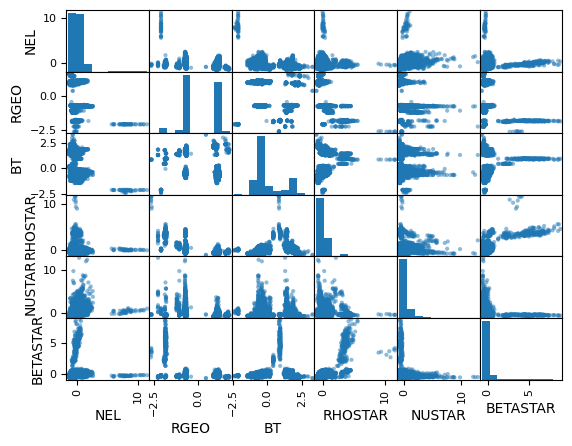

In [20]:
features = ['NEL','RGEO','BT','RHOSTAR','NUSTAR','BETASTAR']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
pd.plotting.scatter_matrix(DB5_);

### BINARY LOGISTIC REGRESSION | THRESHOLD TUNING

[[Jason Brownlee, 2020]](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

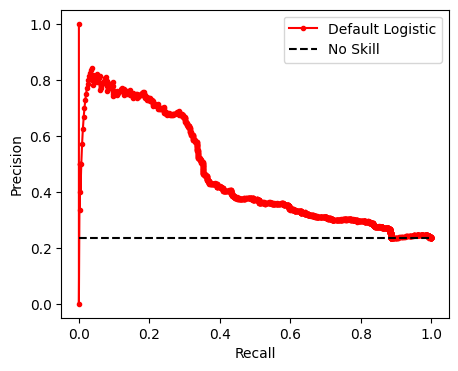

In [21]:
# PR curve for logistic regression model

X = DB5_[features].to_numpy()
y = DB5[["label"]].to_numpy().reshape(-1)

# split data
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)


plt.figure(figsize=(5,4))
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot(recall, precision, marker='.', label='Default Logistic', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

In [22]:
y_pred_ = model.predict(testX)
precision_recall_fscore_support(testy, y_pred_, labels=[1,0])

(array([0.75806452, 0.78335171]),
 array([0.10681818, 0.98955432]),
 array([0.187251  , 0.87446154]),
 array([ 440, 1436]))

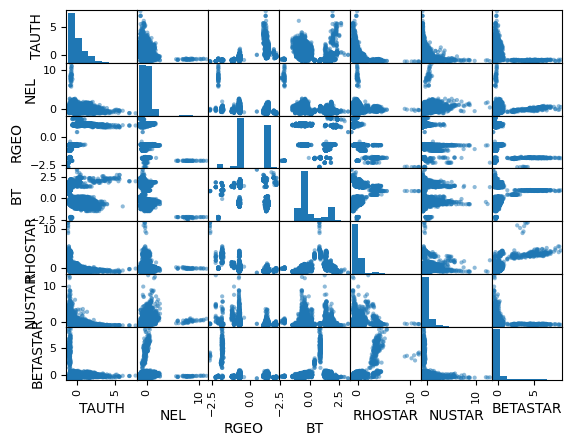

In [23]:
features = ['TAUTH','NEL','RGEO','BT','RHOSTAR','NUSTAR','BETASTAR']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
pd.plotting.scatter_matrix(DB5_);

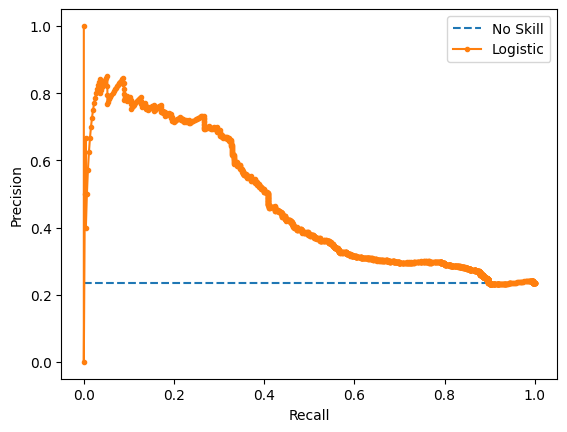

In [10]:
X = DB5_[features].to_numpy()
y = DB5[["label"]].to_numpy().reshape(-1)

# split data
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

In [11]:
y_pred_ = model.predict(testX)
precision_recall_fscore_support(testy, y_pred_, labels=[1,0])

(array([0.77586207, 0.78272827]),
 array([0.10227273, 0.99094708]),
 array([0.18072289, 0.87461586]),
 array([ 440, 1436]))

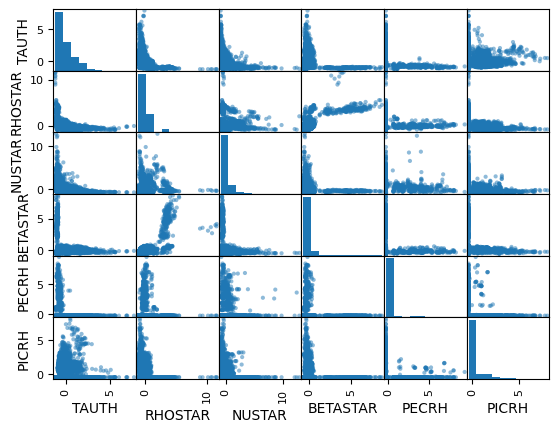

In [12]:
features = ['TAUTH','RHOSTAR','NUSTAR','BETASTAR','PECRH', 'PICRH']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
pd.plotting.scatter_matrix(DB5_);

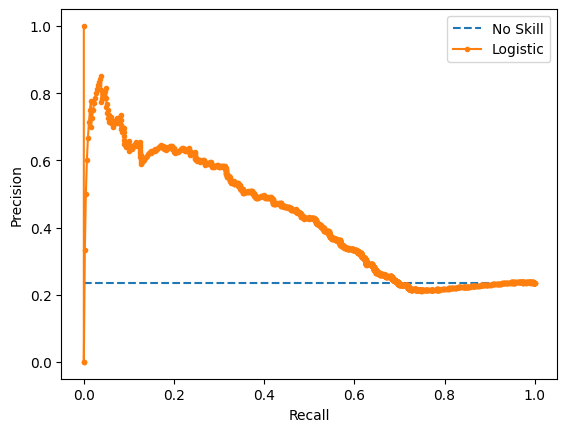

In [13]:
X = DB5_[features].to_numpy()
y = DB5[["label"]].to_numpy().reshape(-1)

# split data
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

In [14]:
y_pred_ = model.predict(testX)
precision_recall_fscore_support(testy, y_pred_, labels=[1,0])

(array([0.68421053, 0.7795492 ]),
 array([0.08863636, 0.98746518]),
 array([0.15694165, 0.87127496]),
 array([ 440, 1436]))

## Entropy Ranked Features

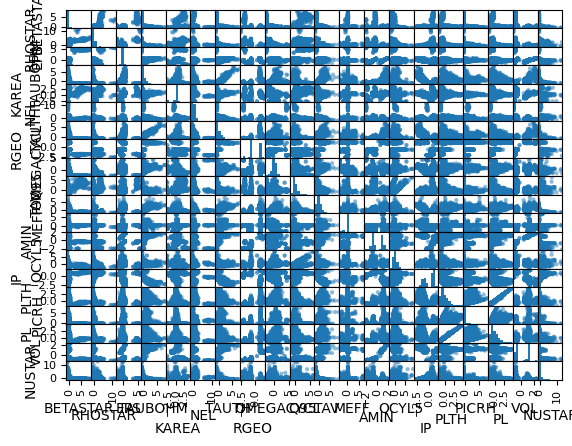

In [15]:
features = ['BETASTAR', 'RHOSTAR', 'EPS', 'TAUBOHM', 'KAREA', 'NEL', 'TAUTH', 
            'RGEO', 'OMEGACYCL', 'Q95', 'TAV', 'MEFF', 'AMIN', 'QCYL5', 'IP', 
            'PLTH', 'PICRH', 'PL', 'VOL', 'NUSTAR']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
pd.plotting.scatter_matrix(DB5_);

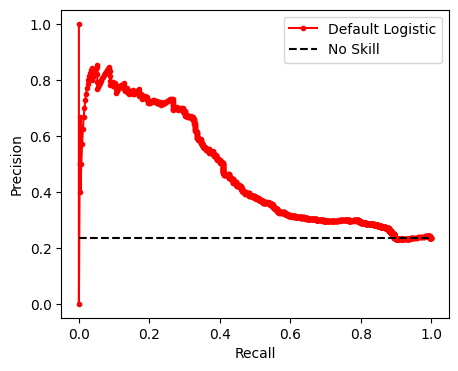

In [24]:
df = DB5_[features]
df["label"] = DB5["label"]
df = df.dropna()

X = df[features].to_numpy()
y = df[["label"]].to_numpy().reshape(-1)

# split data
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)

plt.figure(figsize=(5,4))
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot(recall, precision, marker='.', label='Default Logistic', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

In [25]:
y_pred_ = model.predict(testX)
precision_recall_fscore_support(testy, y_pred_, labels=[1,0])

(array([0.77586207, 0.78272827]),
 array([0.10227273, 0.99094708]),
 array([0.18072289, 0.87461586]),
 array([ 440, 1436]))